## Imports and Setup

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_theme()

## Data Loading

In [192]:
df_train = pd.read_csv("train.csv", index_col=0)
df_test = pd.read_csv("test.csv", index_col=0)
df_train.index.name = None
df_test.index.name = None

In [4]:
df_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [5]:
df_test.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [6]:
df_train.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [7]:
df_test.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
dtype: int64

Fortunately, there are no missing values, so there's no imputation required.

## Data Analysis

We'll start by a simple description of the data

In [8]:
df_train.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [9]:
df_train["Sex"].value_counts()

M    27084
I    23957
F    23010
Name: Sex, dtype: int64

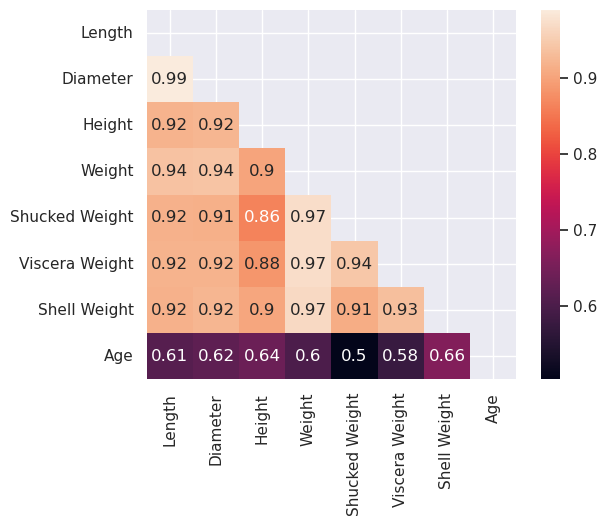

In [10]:
aux = df_train.corr(numeric_only=True)
mask = np.triu(np.ones_like(aux, dtype=bool))
sns.heatmap(aux, mask=mask, square=True, annot=True);

The features are very correlated among themselves, but not with the target variable.

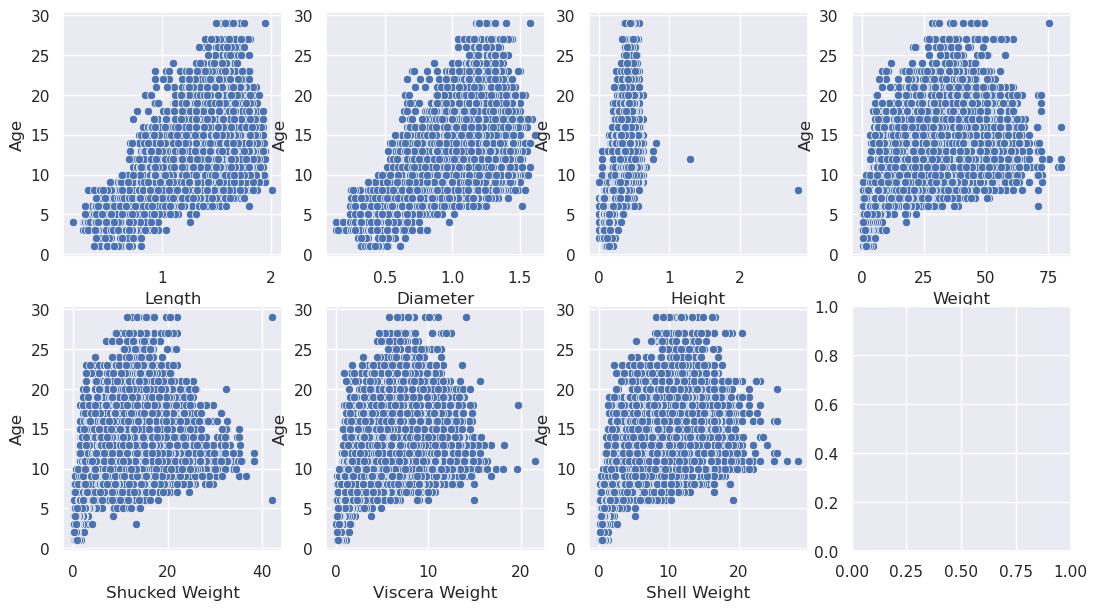

In [11]:
columns = df_train.columns[1:-1]
fig, axs = plt.subplots(2, 4, figsize=(13,7))
for i in range(len(columns)):
    x_cord = i//4
    y_cord = i % 4
    ax = axs[x_cord][y_cord]
    sns.scatterplot(data=df_train, x=columns[i], y="Age", ax=ax)

There seems to be something strange in the "height" field, let's take a closer look.

In [12]:
df_train[ df_train["Height"] > 1 ]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
4704,M,1.7625,1.4125,1.2875,62.652395,31.397071,11.637470,14.514944,12
19023,F,1.2375,0.9500,2.8250,16.839603,9.412034,3.288542,3.784658,8
55879,I,1.1375,0.8875,2.8250,16.839603,9.412034,4.068153,3.784658,8


<Axes: xlabel='Height', ylabel='Weight'>

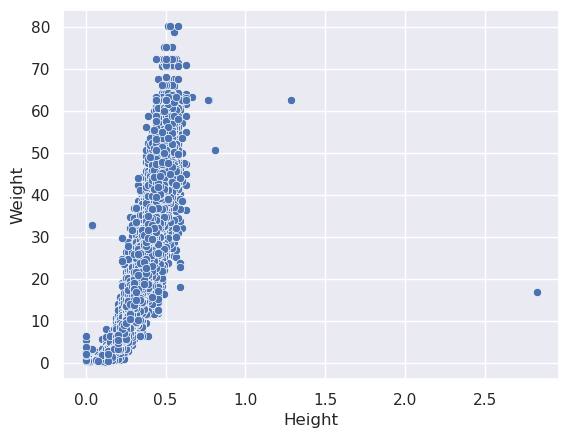

In [13]:
sns.scatterplot(data=df_train, x="Height", y="Weight")

Those points with height greater than 1.0 seem to be major outliers, possibly an input error, so we'll discard them when doing the model training. Also, the fact that two of them are exactly the same (2.825) further lends credence to the idea of a typo or some other error.

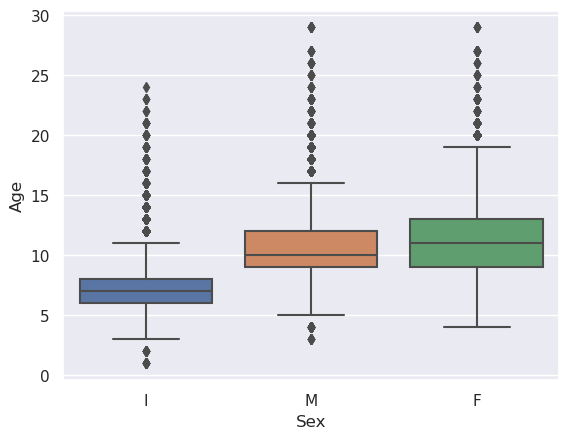

In [14]:
sns.boxplot(data=df_train, x="Sex", y="Age");

Crabs with unidentified sex seem to be younger on average than male and female crabs, by a considerable margin. This is likely because younger crabs would have less developed sexual characteristics, so they'd be more likely to be unidentified.

## Cleaning and Feature Engineering

In [15]:
df1 = df_train.copy()

In [16]:
df1 = df1[ df1["Height"] < 1 ] # Removing outliers

First, let's consider the feature "Bounding Box", that is, the product of the crab's dimensions, which would be the volume that a box encompassing the crab would occupy.

In [17]:
df1["Bounding Box"] = df1["Length"] * df1["Diameter"] * df1["Height"]

We could also create the feature "Density", which would be the crab's weight divided by its bounding box volume.

In [18]:
df1["Density"] = df1["Weight"] / df1["Bounding Box"]

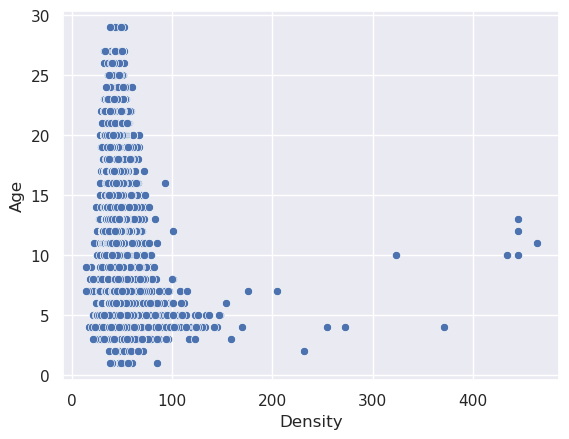

In [19]:
sns.scatterplot(df1, x="Density", y="Age");

The density seems to be pretty constant throughout different ages, so this feature is probably not very useful for this purpose.

Let's try the feature "Shell Proportion", which is the weight of the shell divided by the total weight of the crab

In [20]:
df1["Shell Proportion"] = df1["Shell Weight"] / df1["Weight"]

In [21]:
df1[df1["Shell Proportion"] > 1]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Bounding Box,Density,Shell Proportion
1200,I,0.7875,0.5875,0.2,3.798833,1.630096,0.807961,9.9365,6,0.092531,41.054595,2.615672


Something seems wrong here: A crab has a shell that's heavier than its total weight! That seems like a measuring error, so we'll remove any rows with a Shell Proportion greater than one.

In [22]:
df1 = df1[ df1["Shell Proportion"] < 1]

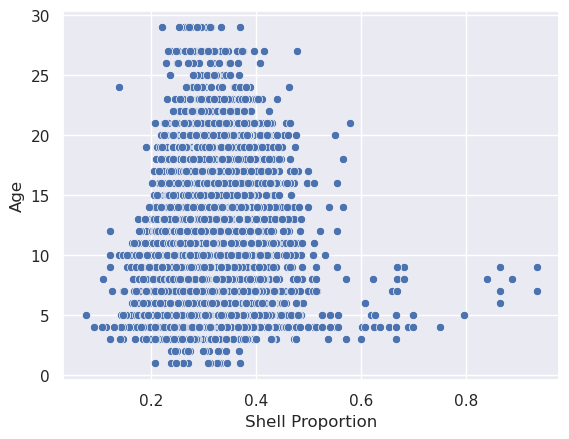

In [23]:
sns.scatterplot(df1, x="Shell Proportion", y="Age");

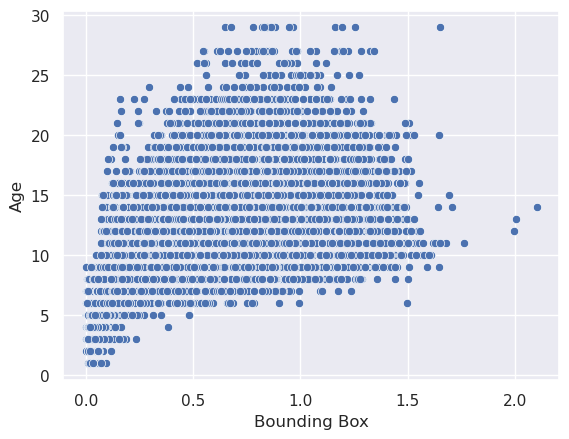

In [24]:
sns.scatterplot(df1, x="Bounding Box", y="Age");

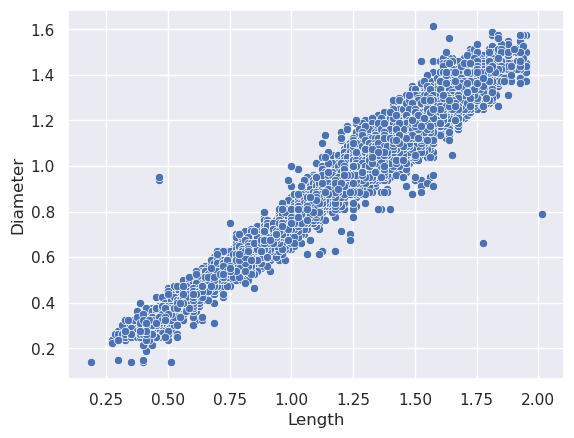

In [25]:
sns.scatterplot(data=df1, x="Length", y="Diameter");

The diameter and length seem so closely correlated that they might be redundant, so we'll probably drop the diameter during the training.

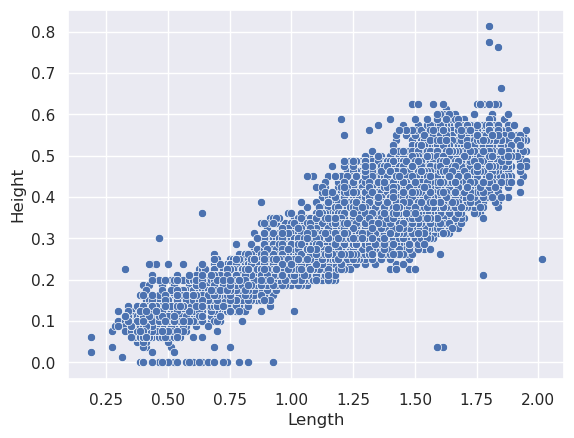

In [26]:
sns.scatterplot(data=df1, x="Length", y="Height");

There seem to be a number of crabs with zero height, which doesn't seem right.

Another feature to be considered would be "Linear Density", that is, the weight divided by the length of the crab.

In [32]:
df1["Linear Density"] = df1["Weight"] / df1["Length"]

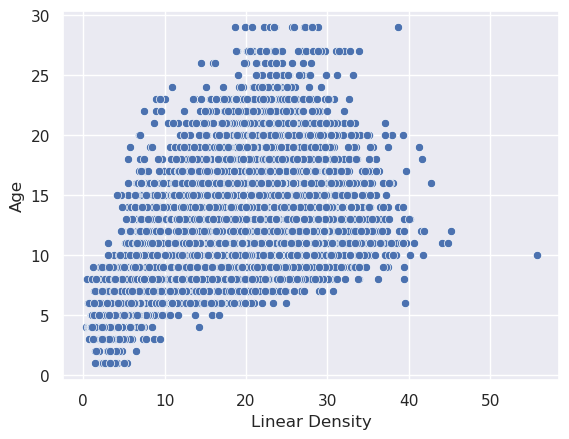

In [33]:
sns.scatterplot(df1, x="Linear Density", y="Age");

In [47]:
df1["Linear Density"].corr(df1["Age"])

0.622490382087608

This feature presents higher correlation than either length or weight on their own, which seems promising.

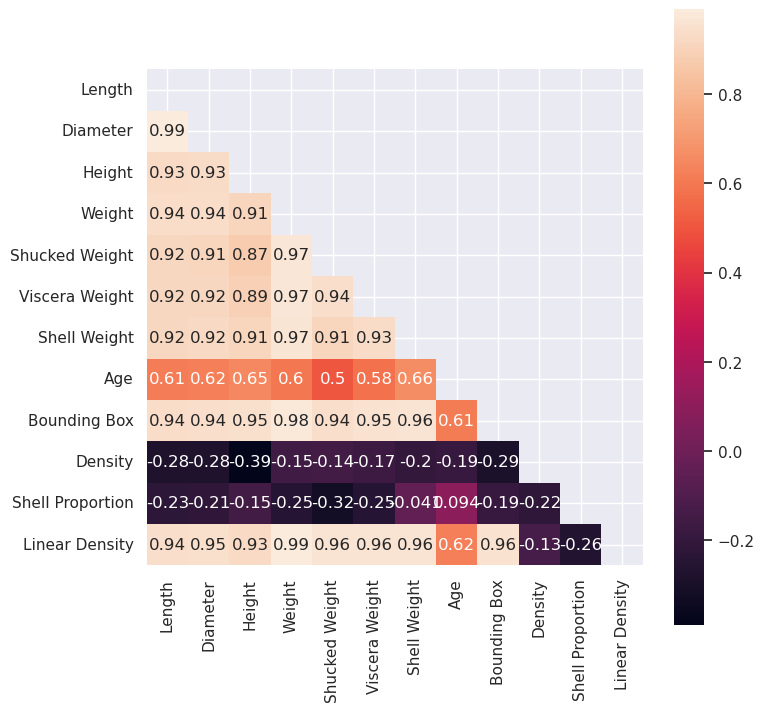

In [58]:
aux = df1.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(8,8))
mask = np.triu(np.ones_like(aux, dtype=bool))
sns.heatmap(aux, mask=mask, square=True, annot=True);

In summary, this is the current plan for the data processing pipeline:

For fitting the model:

1. Remove values of height greater than one or equal to zero
2. Use Linear regression between height and length to impute values removed in step 1
3. Calculate Linear Density
4. Fit and transform target encoding for the Sex
4. Fit and Transform data using the Standard Scaler
5. Select features that will be used: Sex, Height, Diameter and Linear Density

Now we need to write the code.

## Pipeline Creation

In [249]:
class Preprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.height_regressor = LinearRegression()
        self.sex_dict = {}
        
    def fit(self, X_, y_):
        self.X = X_.copy()
        self.y = y_.copy()
        
        # Remove inconsistent data
        self.X.loc[((self.X["Height"] == 0) | (self.X["Height"] > 1)), "Height"] = np.nan
            
        # fit a linear regression to impute removed data
        self.lengthX = self.X["Length"][self.X["Height"].notna()]
        self.heighty = self.X["Height"][self.X["Height"].notna()]
        
        self.height_regressor.fit(np.array(self.lengthX).reshape(-1,1), np.array(heighhy))
        
        # Substitute removed data with linear estimator        
        self.height_preds = self.height_regressor.predict(np.array(self.X["Length"]).reshape(-1,1))
        self.height_preds = pd.Series(self.height_preds, index=self.X.index)
        self.X["Height"].fillna(self.height_preds, inplace=True)
        
        # Calculate linear density
        self.X["Linear Density"] = self.X["Weight"] / self.X["Length"]
        
        # Fit target encoding for sex
        self.df = pd.concat([self.X, self.y], axis=1)
        self.sex_dict = self.df[["Sex", "Age"]].groupby("Sex").mean().to_dict()["Age"]
        
        # Transform target encoding
        self.X["Sex"] = self.X["Sex"].map(self.sex_dict)
        
        # Fit the scaler        
        self.scaler.fit(self.X)
        
        return self
        
    def transform(self, X_, y=None):
        self.X = X_.copy()
            
        # Remove inconsistent data
        self.X.loc[((self.X["Height"] == 0) | (self.X["Height"] > 1)), "Height"] = np.nan
        
        # Substitute removed data with linear estimator        
        self.height_preds = self.height_regressor.predict(np.array(self.X["Length"]).reshape(-1,1))
        self.height_preds = pd.Series(self.height_preds, index=self.X.index)        
        self.X["Height"].fillna(self.height_preds, inplace=True)
        
        # Calculate linear density
        self.X["Linear Density"] = self.X["Weight"] / self.X["Length"]
        
        # Transform target encoding
        self.X["Sex"] = self.X["Sex"].map(self.sex_dict)
        
        
        # Normalize data with the scaler
        self.cols = self.X.columns
        self.X = pd.DataFrame(self.scaler.transform(self.X), columns = self.cols)
        
        # Picks wanted columns
        self.wanted_columns = ["Sex", "Height", "Diameter", "Linear Density"]
        
        return self.X[self.wanted_columns]
        

In [250]:
preproc = Preprocessor()
X_train = df_train.copy()
y_train = X_train.pop("Age")
preproc.fit(X_train, y_train)

In [251]:
cols

Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight'],
      dtype='object')

In [252]:
preproc.transform(X_train)

,Sex,Height,Diameter,Linear Density
0,-1.437123,0.296318,0.633982,0.392933
1,-1.437123,-0.803437,-0.840356,-1.033413
2,0.563112,0.296318,0.370707,0.222089
3,0.833456,1.671012,1.634426,2.010010
4,-1.437123,-0.116090,-0.050532,0.337912
...,...,...,...,...
74046,0.833456,0.983665,1.002567,2.110642
74047,-1.437123,-0.803437,-0.682391,-0.996490
74048,0.833456,0.708726,0.739292,0.515995
74049,-1.437123,-0.391029,-0.261152,-0.380899


In [221]:
pd.DataFrame(preproc.transform(X_train), columns=cols)

ValueError: Shape of passed values is (74051, 9), indices imply (74051, 8)

In [155]:
aux = df_train.copy()

In [156]:
aux.loc[((aux["Height"] == 0) | (aux["Height"] > 1)), "Height"] = np.nan

In [167]:
aux["Height"].isna().sum()

0

In [121]:
regressor = LinearRegression()

In [122]:
lengthX = aux["Length"][aux["Height"].notna()]
heighhy = aux["Height"][aux["Height"].notna()]
regressor.fit(np.array(lengthX).reshape(-1,1), np.array(heighty))

LinearRegression()

In [165]:
aux["Height"].fillna(pred, inplace=True)

<Axes: xlabel='Height', ylabel='Length'>

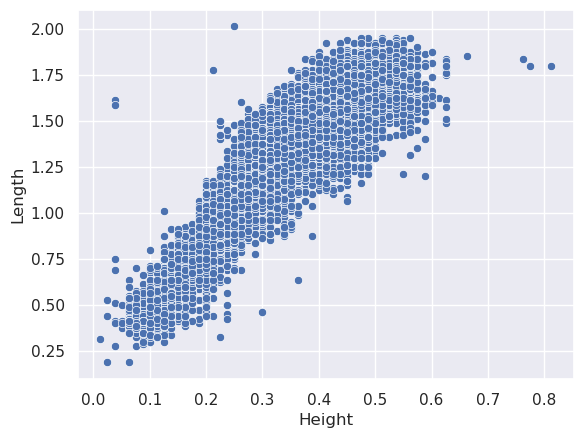

In [166]:
sns.scatterplot(aux, x="Height", y="Length")

In [146]:
len(aux)

74051

In [163]:
pred = pd.Series(regressor.predict(np.array(aux["Length"]).reshape(-1,1)),)

In [149]:
len(pred)

74051

In [161]:
pd.Series(pred)

0        0.408949
1        0.284253
2        0.368606
3        0.460294
4        0.328263
           ...   
74046    0.449291
74047    0.276918
74048    0.397946
74049    0.317261
74050    0.229240
Length: 74051, dtype: float64

In [179]:
dic = aux[["Sex", "Age"]].groupby("Sex").mean().to_dict()["Age"]

In [183]:
aux["Sex"].map(dic)

0         7.599073
1         7.599073
2        10.895953
3        11.341547
4         7.599073
           ...    
74046    11.341547
74047     7.599073
74048    11.341547
74049     7.599073
74050     7.599073
Name: Sex, Length: 74051, dtype: float64

In [184]:
dic

{'F': 11.341547153411561, 'I': 7.59907333973369, 'M': 10.89595333037956}